<a href="https://colab.research.google.com/github/lovepreetmultani/python/blob/main/HeartFailurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
heart_data =pd.read_csv("drive/My Drive/Datasets/heart.csv")

In [5]:
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
heart_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

<Axes: >

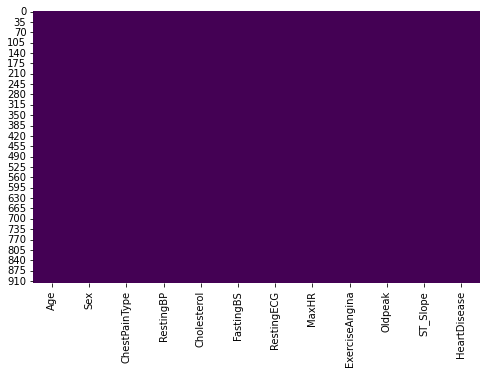

In [7]:
plt.figure(figsize=(8,5))
sns.heatmap(heart_data.isnull(),cbar=False,cmap='viridis')

In [8]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [9]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


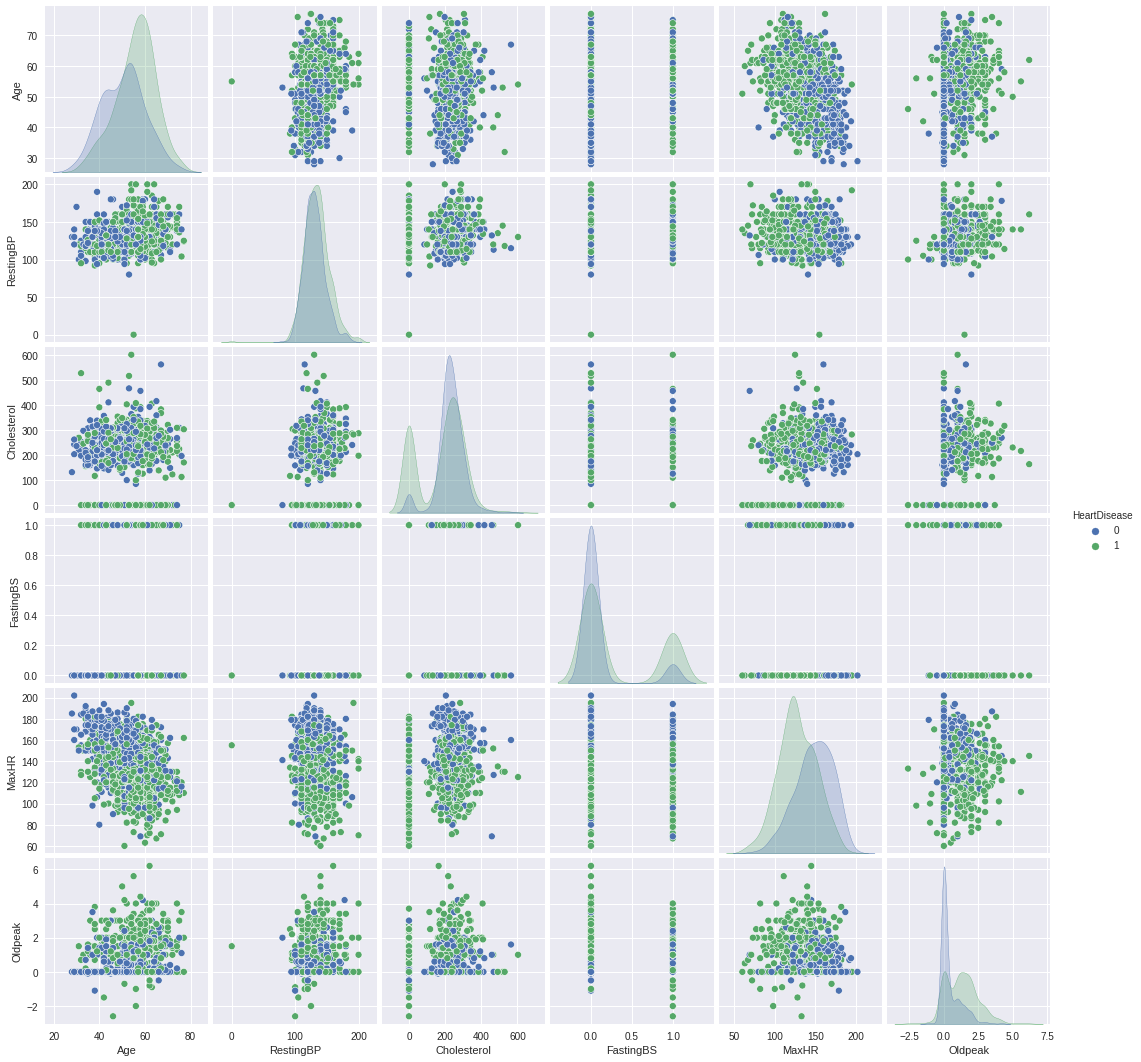

In [96]:
sns.pairplot(data=heart_data, hue='HeartDisease') 

ChestPainType contains 4 types which are : 
1. ATA
2. NAP
3. ASY
4. TA
----------------------------
Count for each type :::
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
----------------------------
----------------------------


Text(0.5, 1.0, 'Counts of Each class of ChestPainType')

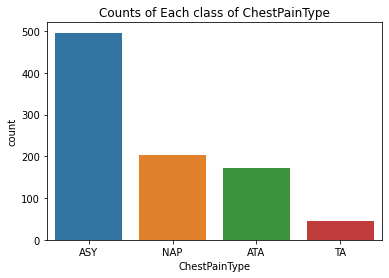

In [10]:
print("ChestPainType contains 4 types which are : ")
i=1
for x in heart_data['ChestPainType'].unique():
  print("{}. {}".format(i,x))
  i = i + 1
print("----------------------------")
print("Count for each type :::")
print(heart_data['ChestPainType'].value_counts())
print("----------------------------")
print("----------------------------")
plt.figure(figsize = (6,4))
sns.countplot(x=heart_data['ChestPainType'], order= ['ASY','NAP','ATA','TA'])
plt.title("Counts of Each class of ChestPainType")

ST_Slope contains 3 types which are : 
1. Up
2. Flat
3. Down
----------------------------
Count for each type :::
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64
----------------------------
----------------------------


Text(0.5, 1.0, 'Counts of Each class of ST_Slope')

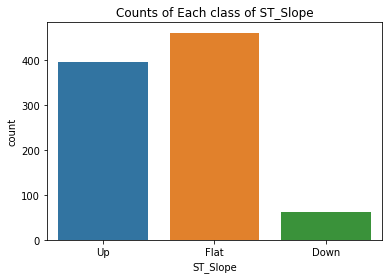

In [11]:
print("ST_Slope contains 3 types which are : ")
i=1
for x in heart_data['ST_Slope'].unique():
  print("{}. {}".format(i,x))
  i = i + 1
print("----------------------------")
print("Count for each type :::")
print(heart_data['ST_Slope'].value_counts())
print("----------------------------")
print("----------------------------")
plt.figure(figsize = (6,4))
sns.countplot(x=heart_data['ST_Slope'])
plt.title("Counts of Each class of ST_Slope")

RestingECG contains 3 types which are : 
1. Normal
2. ST
3. LVH
----------------------------
Count for each type :::
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64
----------------------------
----------------------------


Text(0.5, 1.0, 'Counts of Each class of RestingECG')

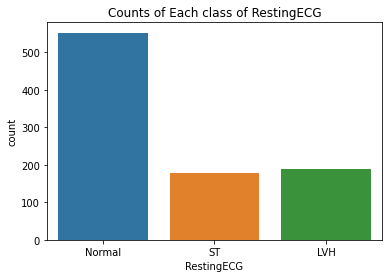

In [12]:
print("RestingECG contains 3 types which are : ")
i=1
for x in heart_data['RestingECG'].unique():
  print("{}. {}".format(i,x))
  i = i + 1
print("----------------------------")
print("Count for each type :::")
print(heart_data['RestingECG'].value_counts())
print("----------------------------")
print("----------------------------")
plt.figure(figsize = (6,4))
sns.countplot(x=heart_data['RestingECG'])
plt.title("Counts of Each class of RestingECG")

In [13]:
binary_variables = ['Sex','FastingBS','ExerciseAngina','HeartDisease'] 

for variable in binary_variables:
  print("Count for each type of {} :::".format(variable))
  print(heart_data[variable].value_counts())
  print("----------------------------")

Count for each type of Sex :::
M    725
F    193
Name: Sex, dtype: int64
----------------------------
Count for each type of FastingBS :::
0    704
1    214
Name: FastingBS, dtype: int64
----------------------------
Count for each type of ExerciseAngina :::
N    547
Y    371
Name: ExerciseAngina, dtype: int64
----------------------------
Count for each type of HeartDisease :::
1    508
0    410
Name: HeartDisease, dtype: int64
----------------------------


# ***Exploratory Data Analysis***

<ipython-input-14-103a604226df>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 576x396 with 0 Axes>

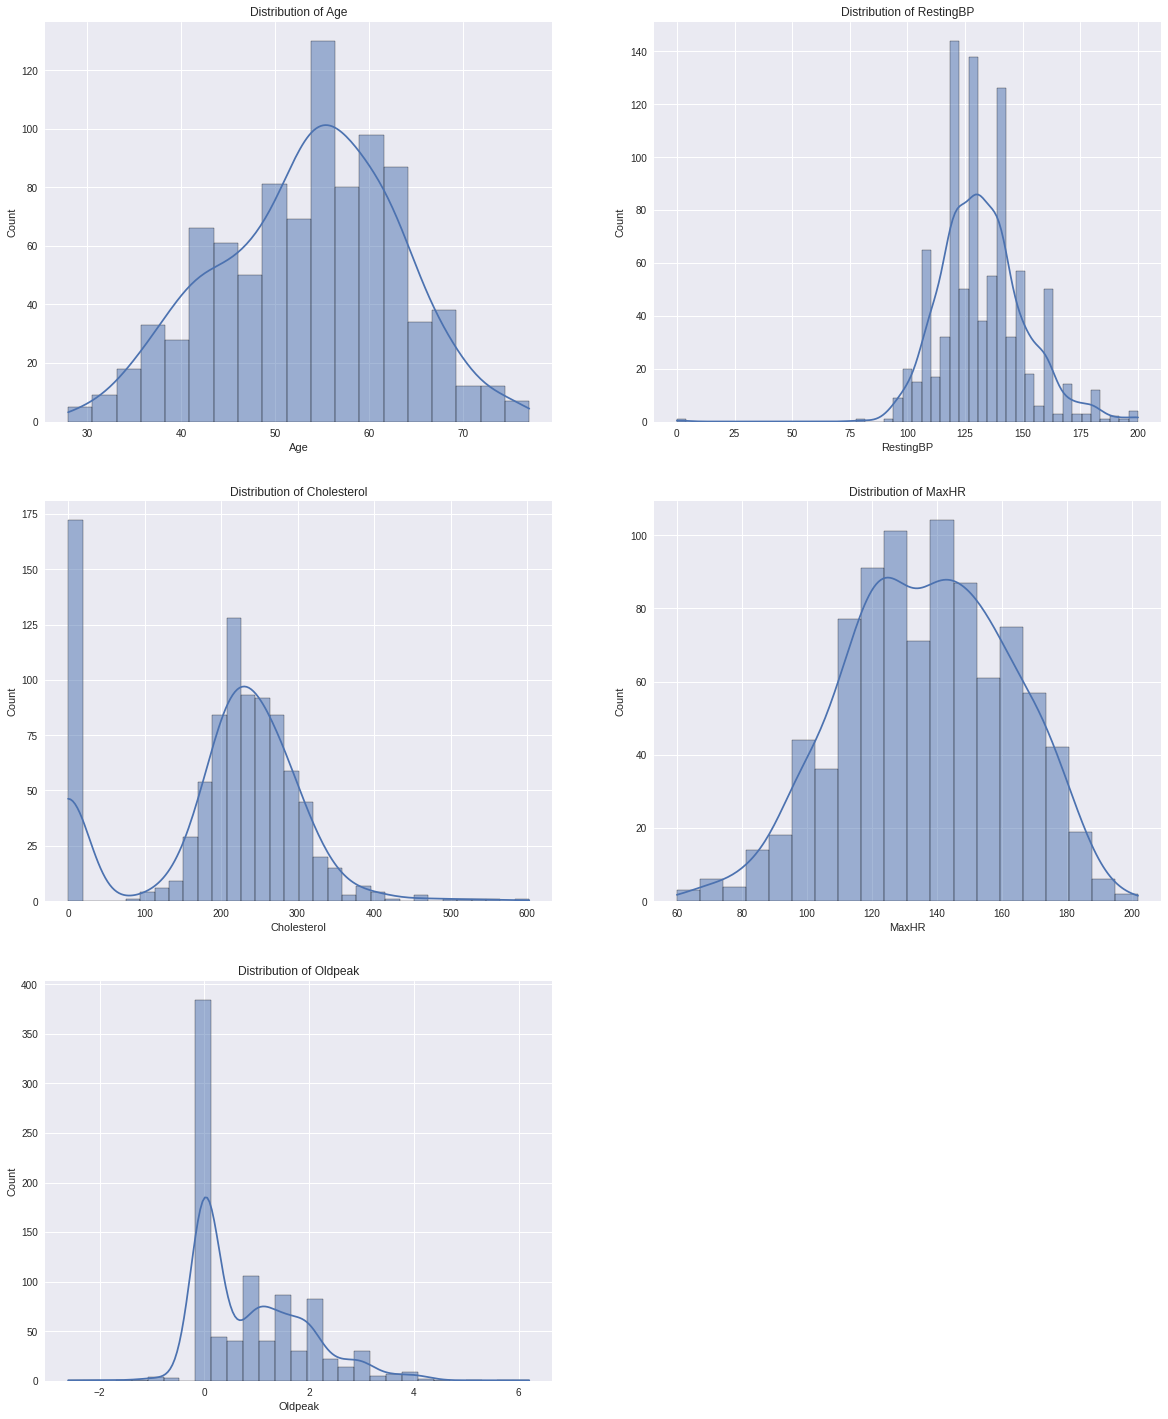

In [14]:
numerical_variables = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
plt.style.use("seaborn")
plt.subplots_adjust(top=0.9,hspace=6,wspace = 1)
plt.figure(figsize=(20,25))
plt.subplot(3,2,1)
i=1
for feature in heart_data.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.histplot(data=heart_data, x=feature, kde=True)
        plt.title("Distribution of {}".format(feature))
        i+=1

Text(0.5, 1.0, 'Distribution of HeartDisease')

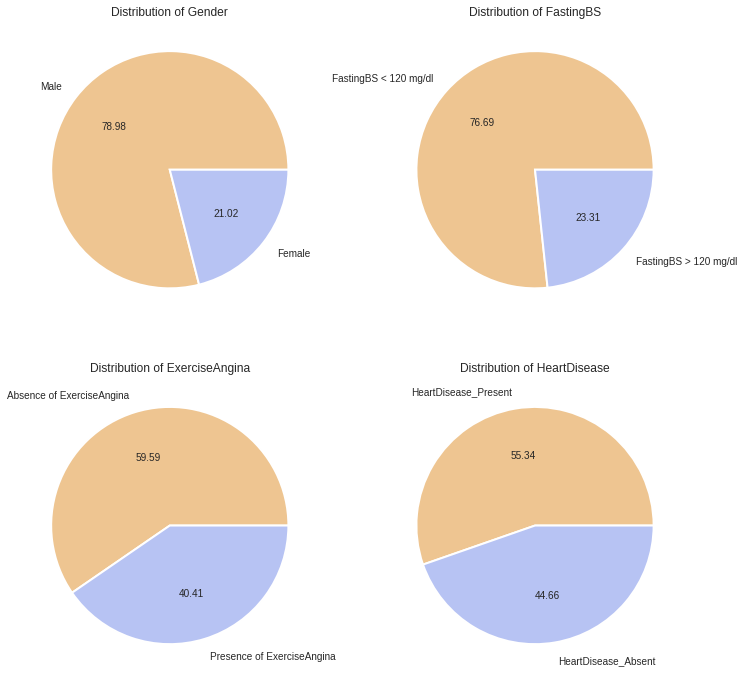

In [15]:
binary_variables = ['Sex','FastingBS','ExerciseAngina','HeartDisease'] 
colors = ['#EEC591', '#B7C3F3']
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
values = heart_data['Sex'].value_counts()
labels = ['Male','Female']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors, autopct= '%.2f');
plt.title("Distribution of Gender")
plt.subplot(2,2,2)
values = heart_data['FastingBS'].value_counts()
labels = ['FastingBS < 120 mg/dl','FastingBS > 120 mg/dl']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors, autopct= '%.2f');
plt.title("Distribution of FastingBS")
plt.subplot(2,2,3)
values = heart_data['ExerciseAngina'].value_counts()
labels = ['Absence of ExerciseAngina','Presence of ExerciseAngina']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors,autopct= '%.2f');
plt.title("Distribution of ExerciseAngina")
plt.subplot(2,2,4)
values = heart_data['HeartDisease'].value_counts() #'#4F6272', '#B7C3F3' 
labels = ['HeartDisease_Present','HeartDisease_Absent']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors,autopct= '%.2f');
plt.title("Distribution of HeartDisease")

Text(0.5, 1.0, 'Counts of Chest pain types')

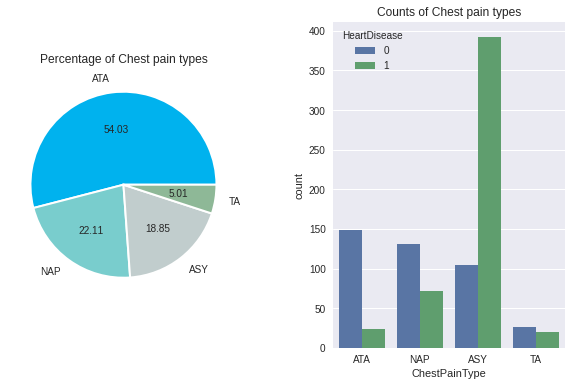

In [16]:
values = heart_data['ChestPainType'].value_counts()
labels = heart_data['ChestPainType'].unique()
colors = ['#00B2EE', '#79CDCD', '#C1CDCD', '#8EB897']
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors,autopct= '%.2f');
plt.title("Percentage of Chest pain types")
plt.subplot(1,2,2)
sns.countplot(x=heart_data['ChestPainType'], hue=heart_data['HeartDisease'])
plt.title("Counts of Chest pain types")

Text(0.5, 1.0, 'Counts of ST_Slope')

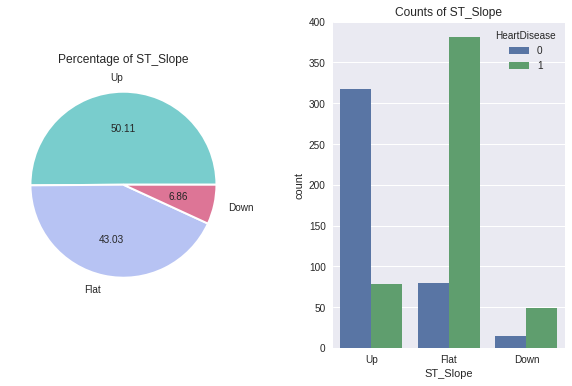

In [17]:
values = heart_data['ST_Slope'].value_counts()
labels = heart_data['ST_Slope'].unique()
colors = ['#79CDCD', '#B7C3F3', '#DD7596', '#8EB897']
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors,autopct= '%.2f');
plt.title("Percentage of ST_Slope")
plt.subplot(1,2,2)
sns.countplot(x=heart_data['ST_Slope'], hue=heart_data['HeartDisease'])
plt.title("Counts of ST_Slope")

Text(0.5, 1.0, 'Counts of RestingECG classes')

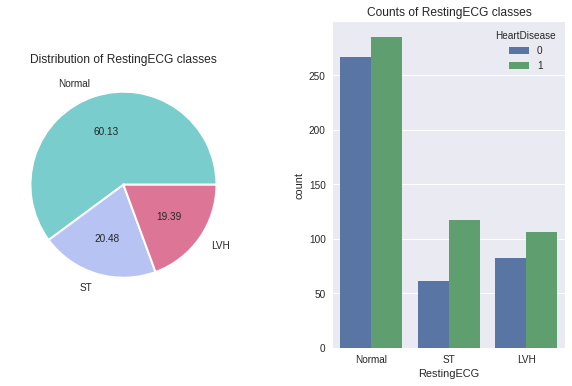

In [18]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
values = heart_data['RestingECG'].value_counts()
labels = heart_data['RestingECG'].unique()
colors = ['#79CDCD', '#B7C3F3', '#DD7596', '#8EB897']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors,autopct= '%.2f');
plt.title("Distribution of RestingECG classes")
plt.subplot(1,2,2)
sns.countplot(x=heart_data['RestingECG'], hue=heart_data['HeartDisease'])
plt.title("Counts of RestingECG classes")

<ipython-input-19-c9c2f11dbe13>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 576x396 with 0 Axes>

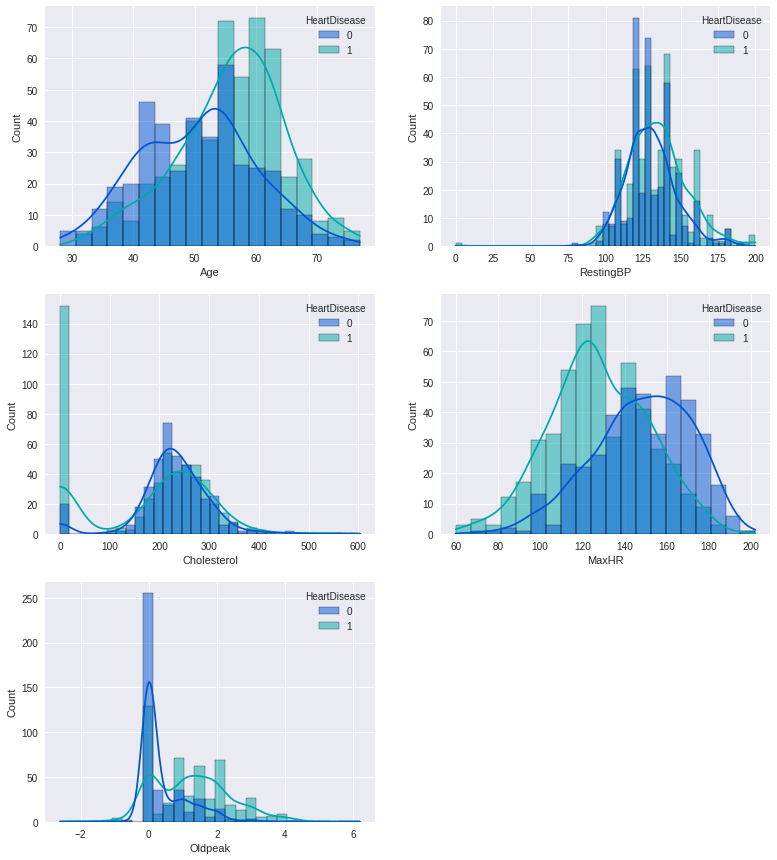

In [19]:
numerical_variables = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2,wspace = 0.4)
plt.figure(figsize=(13,15))
plt.subplot(3,2,1)
i=1
for feature in heart_data.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.histplot(data=heart_data, x=feature, kde=True, palette="winter", hue='HeartDisease')
        i+=1

<Axes: xlabel='HeartDisease', ylabel='Sex'>

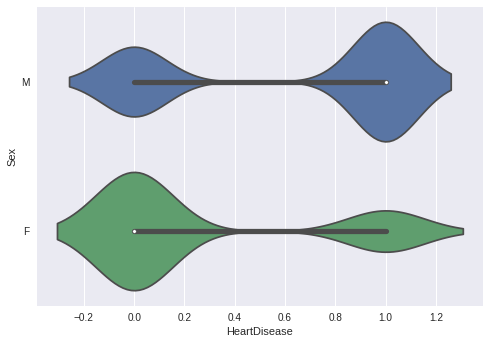

In [20]:
sns.violinplot(x = heart_data['HeartDisease'] , y = heart_data['Sex']) # which specific gender is most likely to have heart Disease

Text(0.5, 1.0, 'Age vs Cholesterol')

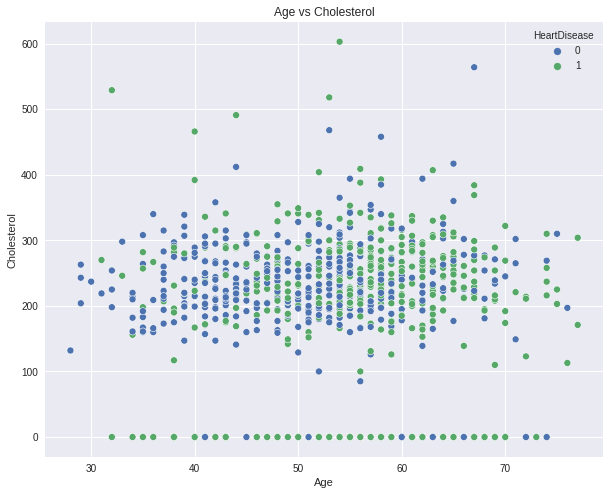

In [21]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart_data["Age"], y=heart_data["Cholesterol"],hue = heart_data['HeartDisease']).set_title("Age vs Cholesterol")

Text(0.5, 1.0, 'Age vs MaxHR')

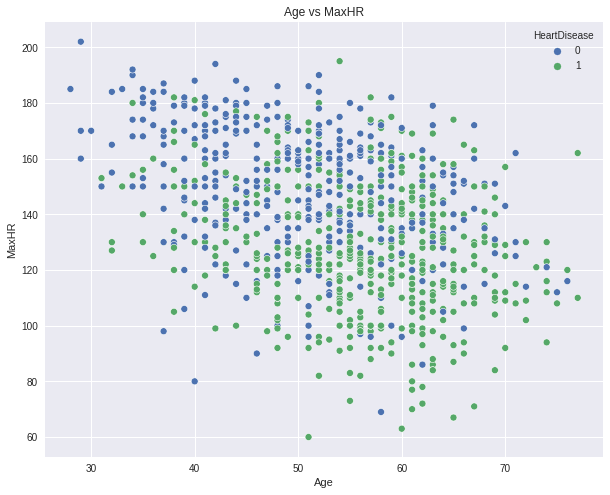

In [22]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart_data["Age"], y=heart_data["MaxHR"],hue = heart_data['HeartDisease']).set_title("Age vs MaxHR")

Text(0.5, 1.0, 'Age vs RestingBP')

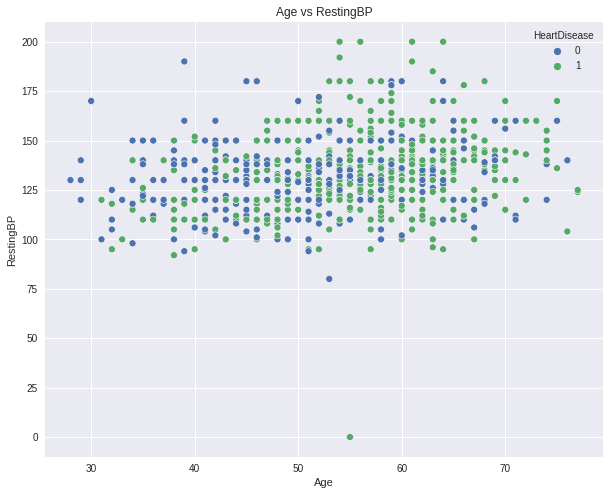

In [23]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart_data["Age"], y=heart_data["RestingBP"],hue = heart_data['HeartDisease']).set_title("Age vs RestingBP")

Text(0.5, 1.0, 'Age vs Oldpeak')

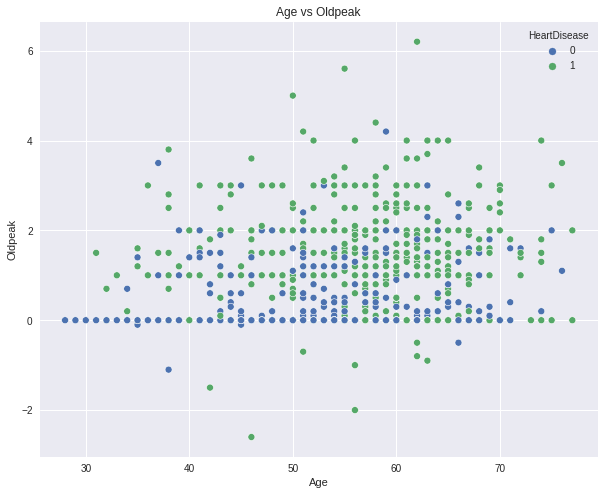

In [24]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart_data["Age"], y=heart_data["Oldpeak"],hue = heart_data['HeartDisease']).set_title("Age vs Oldpeak")

#Detecting and Outliers

<ipython-input-25-399bc7674644>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 576x396 with 0 Axes>

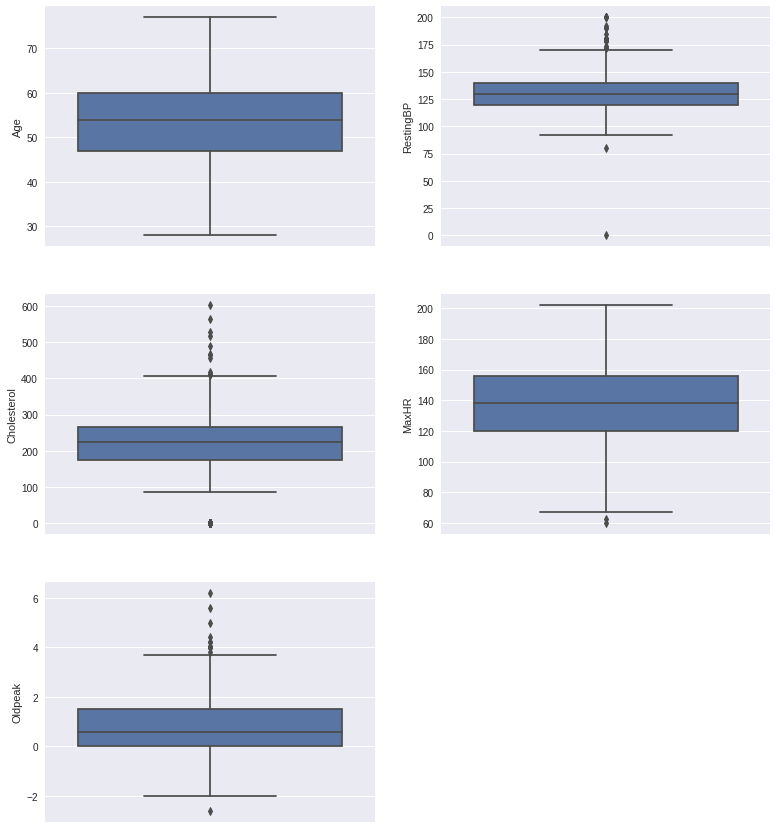

In [25]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.6,wspace = 0.4)
plt.figure(figsize=(13,15))
plt.subplot(3,2,1)
i=1
for feature in heart_data.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.boxplot(y=heart_data[feature])
        i+=1

In [26]:
temp = heart_data.copy()

In [27]:
for variable in numerical_variables:
  stat, p = stats.shapiro(temp[variable])

  alpha = 0.05
  if p > alpha:
      print('"{}" looks normally distributed (fail to reject H0)'.format(variable))
  else:
      print('"{}" does not look normally distributed (reject H0)'.format(variable))
  print(" ")

"Age" does not look normally distributed (reject H0)
 
"RestingBP" does not look normally distributed (reject H0)
 
"Cholesterol" does not look normally distributed (reject H0)
 
"MaxHR" does not look normally distributed (reject H0)
 
"Oldpeak" does not look normally distributed (reject H0)
 


In [28]:
# Calculate the IQR of the data
Q1 = temp['Cholesterol'].quantile(0.25)
Q3 = temp['Cholesterol'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper and lower bounds for outliers
upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

# Identify the outliers in the dataframe
outliers = temp[(temp['Cholesterol'] < lower_bound) | (temp['Cholesterol'] > upper_bound)].dropna()

# Delete the outliers from the dataframe
temp= temp.drop(outliers.index)

In [29]:
Q1 = temp['Oldpeak'].quantile(0.25)
Q3 = temp['Oldpeak'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['Oldpeak'] < lower_bound) | (temp['Oldpeak'] > upper_bound)].dropna()

temp= temp.drop(outliers.index)

In [30]:
Q1 = temp['RestingBP'].quantile(0.25)
Q3 = temp['RestingBP'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['RestingBP'] < lower_bound) | (temp['RestingBP'] > upper_bound)].dropna()

temp= temp.drop(outliers.index)

In [31]:
Q1 = temp['MaxHR'].quantile(0.25)
Q3 = temp['MaxHR'].quantile(0.75)
IQR = Q3 - Q1


upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['MaxHR'] < lower_bound) | (temp['MaxHR'] > upper_bound)].dropna()

temp= temp.drop(outliers.index)

In [32]:
Q1 = temp['Age'].quantile(0.25)
Q3 = temp['Age'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['Age'] < lower_bound) | (temp['Age'] > upper_bound)].dropna()

outliers.shape 

(0, 12)

**After Removing Outliers**

<ipython-input-33-708fa0126542>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 576x396 with 0 Axes>

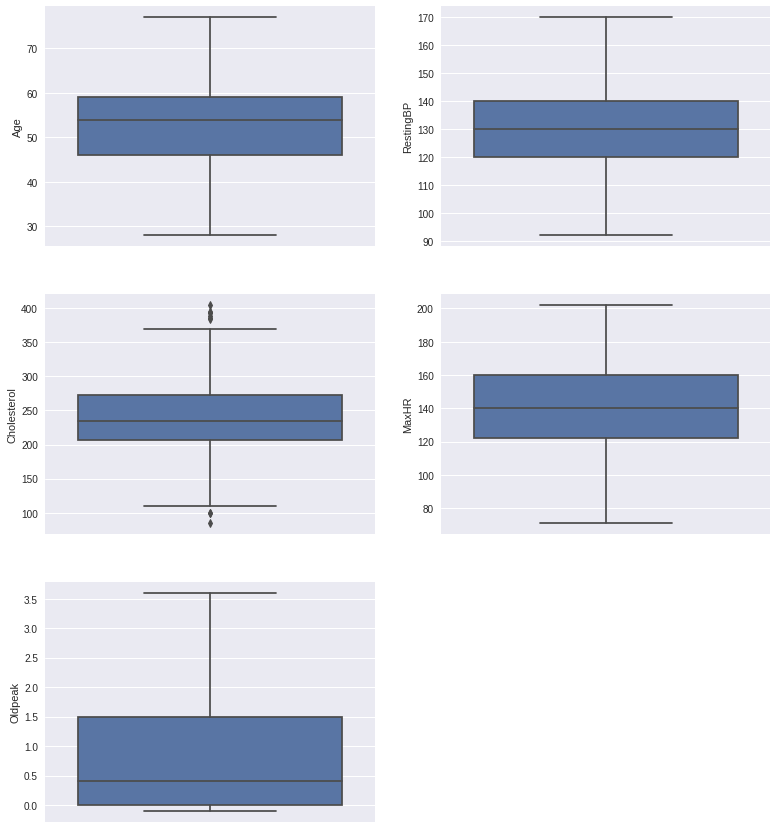

In [33]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.6,wspace = 0.4)
plt.figure(figsize=(13,15))
plt.subplot(3,2,1)
i=1
for feature in temp.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.boxplot(y=temp[feature])
        i+=1

In [34]:
temp.shape

(702, 12)

<Figure size 1440x2880 with 0 Axes>

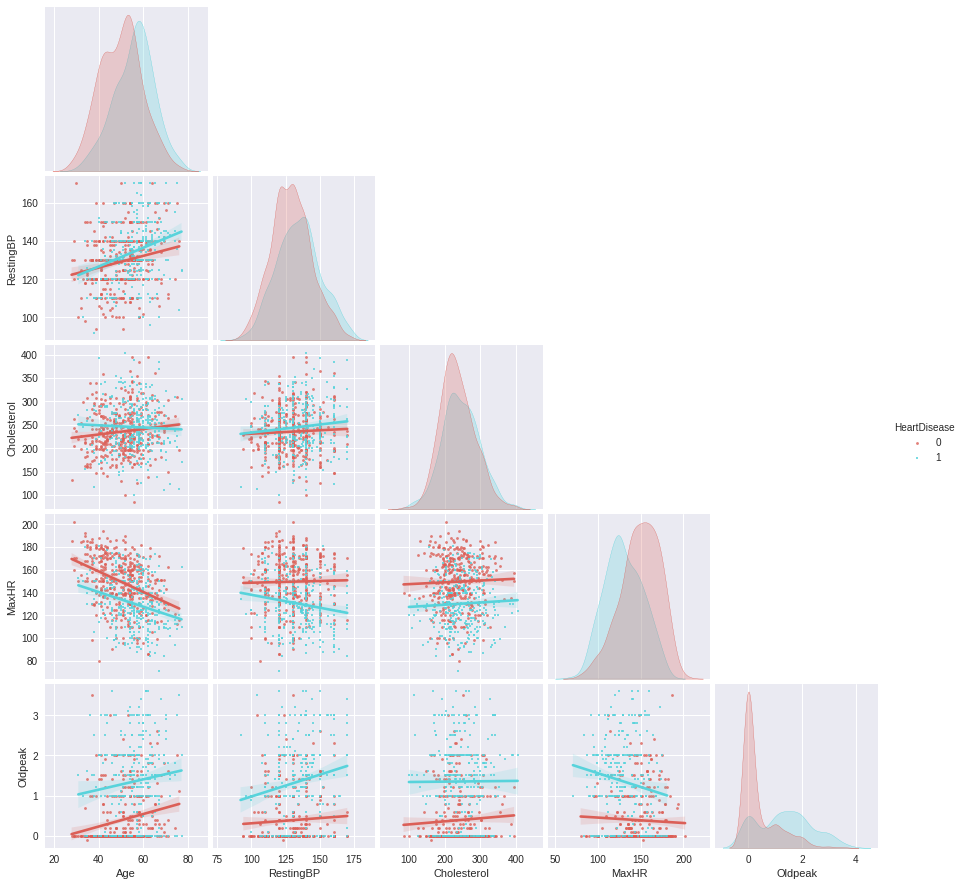

In [35]:
plt.figure(figsize=(20,40))
sns.pairplot(data=temp[numerical_variables + ["HeartDisease"]], hue="HeartDisease", palette='hls', kind="reg", corner=True, markers=["o", "s"], plot_kws={ 'scatter_kws': {'alpha': 0.8, 's':8}})

In [36]:
one_hot_encoder= OneHotEncoder(sparse = False)  # It us not used yet, we will make changes later  
one_hot_encoder.fit_transform(temp[['ChestPainType']])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [37]:
encoded_data = pd.get_dummies(temp, columns = ['Sex','ExerciseAngina','FastingBS','ST_Slope','ChestPainType','RestingECG'],drop_first=True)

<Axes: >

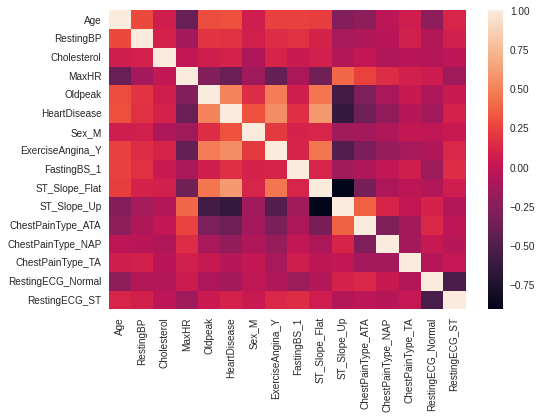

In [38]:
sns.heatmap(encoded_data.corr())

In [39]:
X = encoded_data.drop('HeartDisease', axis = 1)
y = encoded_data[['HeartDisease']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [40]:
scaler = StandardScaler()
pca = PCA(0.95)

In [41]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test) 

In [42]:
PCA_X_train = pca.fit_transform(scaled_X_train)
PCA_X_test = pca.transform(scaled_X_test)

In [43]:
PCA_X_train.shape

(596, 13)

In [44]:
from sklearn.tree import DecisionTreeClassifier 
import time
from datetime import datetime as dt

In [45]:
dtree=DecisionTreeClassifier(criterion="gini")

In [46]:
t0 = dt.now()
print("Training time before:", (dt.now()-t0).seconds)

Training time before: 0


In [53]:
dtree.fit(X_train,y_train)
#dtree.fit(scaled_X_train,y_train)
#dtree.fit(PCA_X_train,y_train)

DecisionTreeClassifier()

In [54]:
print("Training time before:", (dt.now()-t0).seconds)

Training time before: 114


In [55]:
pred=dtree.predict(X_test)
#pred=dtree.predict(scaled_X_test)
#pred=dtree.predict(PCA_X_test)

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

Confusion Matrix:
[[47 12]
 [12 35]]


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        59
           1       0.74      0.74      0.74        47

    accuracy                           0.77       106
   macro avg       0.77      0.77      0.77       106
weighted avg       0.77      0.77      0.77       106



Accuracy: 0.7735849056603774


Precision: 0.7706455102776776
Recall: 0.7706455102776776
0.7706455102776777


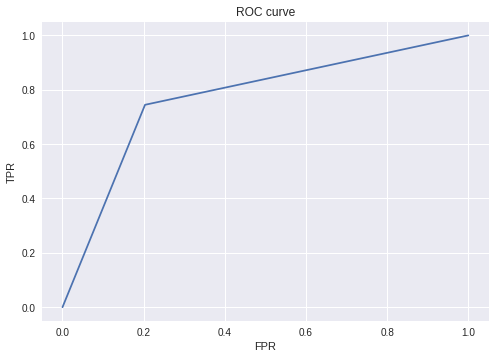

In [60]:
result = confusion_matrix(y_test, pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,pred)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

# print the results
print("Precision:", precision)
print("Recall:", recall)

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [61]:
dtree_1 = DecisionTreeClassifier(criterion="entropy")

In [62]:
t1 = dt.now()
print("Training time before:", (dt.now()-t1).seconds)

Training time before: 0


In [63]:
dtree_1 = dtree_1.fit(X_train,y_train)
#dtree_1 = dtree_1.fit(scaled_X_train,y_train)
#dtree_1 = dtree_1.fit(PCA_X_train,y_train)

In [64]:
print("Training time before:", (dt.now()-t1).seconds)

Training time before: 14


In [65]:
y_pred = dtree_1.predict(X_test)
#y_pred = dtree_1.predict(scaled_X_test)
#y_pred = dtree_1.predict(PCA_X_test)

In [66]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# print the results
print("Precision:", precision)
print("Recall:", recall)

Confusion Matrix:
[[48 11]
 [12 35]]


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        59
           1       0.76      0.74      0.75        47

    accuracy                           0.78       106
   macro avg       0.78      0.78      0.78       106
weighted avg       0.78      0.78      0.78       106



Accuracy: 0.7830188679245284


Precision: 0.7804347826086957
Recall: 0.7791200865488641


In [67]:
from sklearn.neighbors import KNeighborsClassifier 

In [91]:
knn= KNeighborsClassifier(n_neighbors=1) 

In [92]:
knn.fit(X_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=1)

In [93]:
pred=knn.predict(X_test)

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [95]:
result = confusion_matrix(y_test, pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,pred)
print("Accuracy:",result2)

Confusion Matrix:
[[34 25]
 [15 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63        59
           1       0.56      0.68      0.62        47

    accuracy                           0.62       106
   macro avg       0.63      0.63      0.62       106
weighted avg       0.64      0.62      0.62       106

Accuracy: 0.6226415094339622


In [79]:
from sklearn.model_selection import cross_val_score

In [ ]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

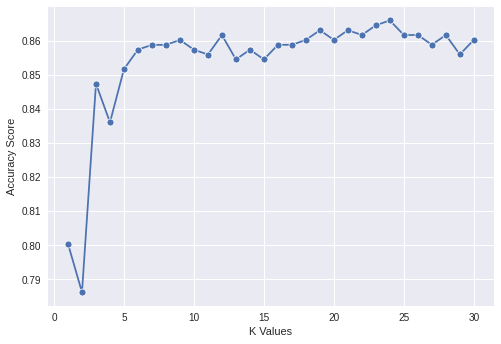

In [81]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [82]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=24)

In [84]:
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
result = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:", result)

Accuracy: 0.6792452830188679
Precision: 0.6756756756756757
Recall: 0.5319148936170213
Confusion Matrix: [[47 12]
 [22 25]]
